# Reconstruction test  
ACAE was trained for 100 epochs 

In [1]:
import argparse
from argparse import RawTextHelpFormatter
import numpy as np
import os

# keras
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, UpSampling2D, Conv2DTranspose, Flatten, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.optimizers import Adam


from absl import app

# logging
import wandb
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec, colors
import shutil
from glob import glob

Using TensorFlow backend.


# Anomaly scores

In [2]:
# load models
encoder = load_model("/home/aogorodnikov/aae/encoder.h5")
decoder = load_model("/home/aogorodnikov/aae/decoder.h5")
discriminator = load_model("/home/aogorodnikov/aae/discriminator.h5")
generator = load_model("/home/aogorodnikov/aae/generator.h5")

Instructions for updating:
Colocations handled automatically by placer.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Instructions for updating:
Use tf.cast instead.


/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/saving.py:350: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [4]:
input_dim = (104,104,3)
latent_dim=32

In [5]:
autoencoder_input = Input(shape=input_dim)
autoencoder = Model(autoencoder_input, decoder(encoder(autoencoder_input)))
autoencoder.compile(optimizer=Adam(lr=1e-4), loss="mean_squared_error", metrics=['accuracy'])

In [6]:
discriminator.compile(optimizer=Adam(lr=1e-4), loss="binary_crossentropy", metrics=['accuracy'])

In [10]:
def anomaly_score(cell_pheno):
    [shutil.rmtree(x) for x in glob("/home/aogorodnikov/test/*")]
    input_dir = os.path.join("/home/aogorodnikov/classes_rgb_corrected/", cell_pheno)
    shutil.copytree(input_dir, os.path.join("/home/aogorodnikov/test/", cell_pheno))
    img_wd = "/home/aogorodnikov/test"
    batch = 56
    input_dim = (104,104,3)
    data_loader = ImageDataGenerator(
        rescale=1. / 255,
        featurewise_center=True,
        featurewise_std_normalization=True,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    train_data = data_loader.flow_from_directory(
        img_wd,
        target_size=(input_dim[0], input_dim[0]),
        batch_size=batch,
        class_mode='input')
    
    batch_index = 0
    discriminator_batch_losses = []
    while batch_index <= train_data.batch_index:
        data = train_data.next()
        data_list = data[0]
        data_size = len(data_list)

        fake_latent = encoder.predict(data_list)
        discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))
        discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
        discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)
        
        batch_index = batch_index + 1
        discriminator_batch_losses.append(discriminator_history[0])
    
    
    
    
    ae_res = autoencoder.evaluate_generator(train_data)[0]
    adv_res = np.mean(discriminator_batch_losses)
    
    print('Class: {}\nae_loss: {}\nadv_loss: {}'.format(cell_pheno, ae_res, adv_res))
    return ae_res, adv_res
    
        

In [11]:
dirs = [x for x in os.listdir("/home/aogorodnikov/classes_rgb_corrected/") if os.path.isdir(os.path.join("/home/aogorodnikov/classes_rgb_corrected/", x))]

In [12]:
results = [[x, anomaly_score(cell_pheno=x)] for x in dirs]

Found 684 images belonging to 1 classes.
24/24 [==============================] - 0s 185us/step
Class: confluent
ae_loss: 0.005258663848848545
adv_loss: 0.7539176023923434
Found 313 images belonging to 1 classes.
66/66 [==============================] - 0s 285us/step
Class: cytokinesis
ae_loss: 0.00601810167808407
adv_loss: 0.6828084366576151
Found 1124 images belonging to 1 classes.
8/8 [==============================] - 0s 376us/step
Class: negative
ae_loss: 0.004710673785427075
adv_loss: 0.676718733748611
Found 310 images belonging to 1 classes.
60/60 [==============================] - 0s 266us/step
Class: nuclear_mess
ae_loss: 0.0060687497378357
adv_loss: 0.7787307026840392
Found 857 images belonging to 1 classes.
34/34 [==============================] - 0s 324us/step
Class: large_nuclei
ae_loss: 0.005075864936143612
adv_loss: 0.7787385018651976
Found 1077 images belonging to 1 classes.
26/26 [==============================] - 0s 181us/step
Class: other
ae_loss: 0.00401528386750233

In [13]:
results

[['confluent', (0.005258663848848545, 0.7539176023923434)],
 ['cytokinesis', (0.00601810167808407, 0.6828084366576151)],
 ['negative', (0.004710673785427075, 0.676718733748611)],
 ['nuclear_mess', (0.0060687497378357, 0.7787307026840392)],
 ['large_nuclei', (0.005075864936143612, 0.7787385018651976)],
 ['other', (0.004015283867502334, 0.7674402850014822)],
 ['micronuclei', (0.0055628577247262, 0.7655910196021228)],
 ['spindle', (0.004585141046796324, 0.6751734975884134)],
 ['Y', (0.00529486717035373, 0.7664512314115253)],
 ['binucleated', (0.004865828377660364, 0.7887121353830611)],
 ['polarity', (0.005126380641013384, 0.7656017473765783)],
 ['croissant', (0.004727188446235758, 0.7406090987139734)]]

In [129]:
np.percentile([x[1] for x in results], 50)

0.005067414907540783

In [121]:
img_wd = "/home/aogorodnikov/classes_rgb_corrected/"
batch = 56
input_dim = (104,104,3)
latent_dim = 64
epoch = 10
conv=True
adversarial=True


In [43]:
# LOAD DATA
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')

Found 7557 images belonging to 12 classes.


In [27]:
data = train_data.next()
data_list = data[0]

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:724: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


In [13]:
def draw(samples):
    fig = plt.figure(figsize=(5 * len(samples), 5))
    gs = gridspec.GridSpec(1, len(samples))
    for i, sample in enumerate(samples):
        ax = plt.Subplot(fig, gs[i])
        ax.imshow((sample["image"] * 255.).astype("int"), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('equal')
        ax.set_title(sample["title"])
        fig.add_subplot(ax)
    plt.show(block=False)

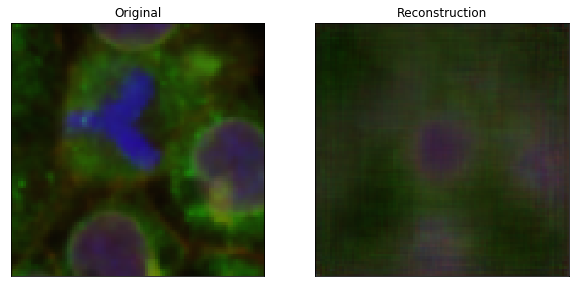

In [15]:
choice = np.random.choice(np.arange(32))
original = data_list[choice]

original_1 = np.expand_dims(original, axis=0)

latent = encoder.predict(original_1)

reconstruction = decoder.predict(latent)

draw([{"title": "Original", "image": original}, {"title": "Reconstruction", "image": reconstruction[0]}])



In [17]:
autoencoder.evaluate_generator(train_data)

[0.005230800629678098, 0.5579293930169308]

In [149]:
data_loader = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_data = data_loader.flow_from_directory(
    img_wd,
    target_size=(input_dim[0], input_dim[0]),
    batch_size=batch,
    class_mode='input')



Found 7557 images belonging to 12 classes.


In [168]:
fake_latent = encoder.predict(data_list)

fake_latent

array([[-4.564788  ,  0.9550102 ,  8.51572   , ..., -0.4226413 ,
        -2.8371184 ,  7.1186886 ],
       [-2.9885685 , -5.655708  ,  3.7550688 , ...,  6.76246   ,
         2.7704573 , -9.528672  ],
       [-1.4381589 , -1.331906  ,  1.8464564 , ..., -4.284677  ,
        -0.1258904 ,  5.611074  ],
       ...,
       [-3.8753633 , -8.207726  , 13.1112995 , ...,  1.2015983 ,
         1.0967643 , -0.73942983],
       [-4.6393876 , -1.6131024 ,  3.0874438 , ...,  1.7831937 ,
         3.7470875 ,  2.2027905 ],
       [-4.1928124 , -7.6067743 ,  1.2030356 , ...,  1.3560551 ,
        13.47506   , -9.464908  ]], dtype=float32)

In [172]:
fake_latent.shape

(56, 32)

In [169]:
discriminator_input = np.concatenate((fake_latent, np.random.randn(data_size, latent_dim) * 5.))


ValueError: all the input array dimensions except for the concatenation axis must match exactly

In [ ]:
discriminator_labels = np.concatenate((np.zeros((data_size, 1)), np.ones((data_size, 1))))
discriminator_history = discriminator.evaluate(x=discriminator_input, y=discriminator_labels)

In [174]:
?encoder

Signature:      encoder(inputs, **kwargs)
Type:           Sequential
String form:    <keras.engine.sequential.Sequential object at 0x7f7d601a8eb8>
File:           ~/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/keras/engine/sequential.py
Docstring:     
Linear stack of layers.

# Arguments
    layers: list of layers to add to the model.
    name: Name given to the model

# Example

```python
# Optionally, the first layer can receive an `input_shape` argument:
model = Sequential()
model.add(Dense(32, input_shape=(500,)))

# Afterwards, we do automatic shape inference:
model.add(Dense(32))

# This is identical to the following:
model = Sequential()
model.add(Dense(32, input_dim=500))

# And to the following:
model = Sequential()
model.add(Dense(32, batch_input_shape=(None, 500)))

# Note that you can also omit the `input_shape` argument:
# In that case the model gets built the first time you call `fit` (or other
# training and evaluation methods).
model = Sequential()
model.add(De